In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
ruta = r'C:\docs\DOCTORADO\Machine_Learning/tornados.csv'  
df = pd.read_csv(ruta)  


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\docs\\DOCTORADO\\Machine_Learning/tornados.csv'

## Autoencoders

In [315]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models
import time

# 1. Preparar datos
X = df_ml.drop('inj', axis=1)
y = df_ml['inj']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Construir Autoencoder
n_input = X_train_scaled.shape[1]
n_encoded = 16  

# Tiempo de entrenamiento
start_time = time.time()

# Codificador
input_layer = layers.Input(shape=(n_input,))
encoded = layers.Dense(n_encoded, activation='relu')(input_layer)

# Decodificador
decoded = layers.Dense(n_input, activation='linear')(encoded)

# Autoencoder completo
autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Codificador como extractor de características
encoder = models.Model(inputs=input_layer, outputs=encoded)

# 3. Usar representaciones comprimidas
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# 4. Modelo de regresión usando la salida del encoder
reg_model = models.Sequential([
    layers.Input(shape=(n_encoded,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

reg_model.compile(optimizer='adam', loss='mse')

# Entrenar modelo de regresión
reg_model.fit(X_train_encoded, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Medir tiempo
training_time = round(time.time() - start_time, 4)

# 5. Evaluar
y_pred = reg_model.predict(X_test_encoded).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 6. Mostrar resultados
print("📊 Evaluación del modelo:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 4))
print("⏱️ Tiempo CPU:", training_time, "segundos")

# DataFrame de resultados
resultados_autoencoder = pd.DataFrame({
    'Modelo': ['Autoencoder + Regresión'],
    'MAE': [round(mae, 2)],
    'RMSE': [round(rmse, 2)],
    'R²': [round(r2, 4)],
    'CPU time (s)': [training_time]
})

resultados_autoencoder


390/390 [==============================] - 1s 1ms/step
📊 Evaluación del modelo:
MAE: 3.08
RMSE: 21.19
R²: 0.3933
⏱️ Tiempo CPU: 381.8383 segundos


,Modelo,MAE,RMSE,R²,CPU time (s)
0,Autoencoder + Regresión,3.08,21.19,0.3933,381.8383


Desde el punto de vista numérico:

- MAE = 3.08: en promedio, el modelo se equivoca en aproximadamente 3 heridos por tornado, lo cual es aceptable considerando la escala de los datos.

- RMSE = 21.19: la raíz del error cuadrático medio indica que los errores más grandes (casos extremos) afectan la media, como se esperaba.

- R² = 0.3933: el modelo explica cerca del 39% de la variabilidad total de los datos. Aunque no es un valor alto, es un resultado razonable considerando que se está utilizando una compresión previa con autoencoder, y que los datos presentan mucha dispersión e incluso outliers.

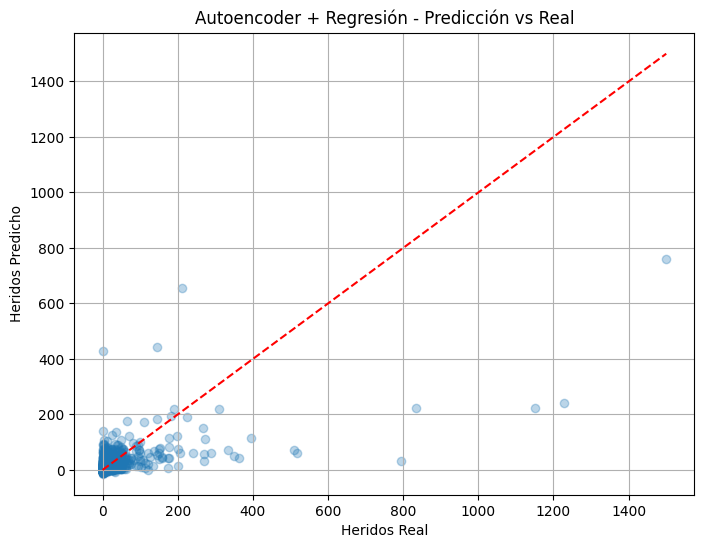

In [317]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Heridos Real")
plt.ylabel("Heridos Predicho")
plt.title("Autoencoder + Regresión - Predicción vs Real")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.grid(True)
plt.show()



La gráfica de dispersión muestra la comparación entre los valores reales de heridos por tornados (inj) y las predicciones realizadas por el modelo Autoencoder + Regresión. Cada punto azul representa un evento individual: el eje X indica la cantidad real de heridos, mientras que el eje Y indica el valor predicho por el modelo. La línea roja discontinua representa una predicción perfecta, es decir, donde el número de heridos predicho coincide exactamente con el valor real.

Aunque la mayoría de los puntos se agrupan cerca del origen, se observa una alta concentración de eventos con pocos heridos, lo cual es coherente con la distribución real de los datos. Sin embargo, también se puede ver que, para los casos con mayor número de heridos (eventos extremos), el modelo tiende a subestimar los valores reales. Esto sugiere que el modelo es bueno captando el comportamiento general, pero le cuesta ajustarse en los extremos.

En conjunto, el modelo logra una predicción razonable para la mayoría de los casos, pero aún tiene margen de mejora, especialmente para eventos con mayor número de heridos. Aun así, puede considerarse útil como una primera aproximación o en escenarios donde los errores extremos no sean críticos.